<a href="https://colab.research.google.com/github/fineliaapp/backtesting-tool/blob/main/colab_backtest_portfolio_fiscalita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtest portafoglio + ribilanciamento + fiscalità italiana (stima)

Questo notebook estende il template precedente aggiungendo:
- gestione **portfolio multi-asset** (holdings + cash)
- ribilanciamento semplice (mensile o con bande)
- stima **fiscalità italiana** sulle vendite usate per ribilanciare (modello semplificato)

> ⚠️ Fiscalità: è un modello **semplificato** (utile per simulazioni). La fiscalità reale dipende da intermediario, strumento, regime fiscale (amministrato/dichiarativo), natura dei proventi e casistiche specifiche.


## 0) Setup cartelle

In [26]:
from pathlib import Path

BASE = Path("/content")
DATA = BASE / "data"
PROC = DATA / "processed"
REPORTS = BASE / "reports"
for p in [PROC, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

PROC, REPORTS


(PosixPath('/content/data/processed'), PosixPath('/content/reports'))

## 1) Install dipendenze

In [2]:
!pip -q install yfinance pyarrow pandas numpy matplotlib requests

## 2) Imports + Config

In [3]:
import math
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from io import StringIO

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 60)


In [4]:
@dataclass
class DataConfig:
    start: str = "2005-01-01"
    end: Optional[str] = None  # None -> oggi
    cache: bool = True

@dataclass
class SyntheticETFConfig:
    # leva e costi
    leverage: float = 1.0
    ter_annual: float = 0.0020
    funding_spread_annual: float = 0.00
    # FX overlay
    base_ccy: str = "USD"
    out_ccy: str = "EUR"
    fx_pair: str = "DEXUSEU"   # FRED: USD per 1 EUR
    fx_unhedged: bool = True
    # label
    name: str = "synthetic"

DATA_CFG = DataConfig(start="2005-01-01", cache=True)


## 3) Cache I/O (Parquet)

In [5]:
def cache_path(kind: str, key: str) -> Path:
    safe = key.replace("/", "_").replace("^", "IDX_").replace("=", "_")
    return PROC / f"{kind}__{safe}.parquet"

def save_parquet(df: pd.DataFrame, path: Path) -> None:
    df.to_parquet(path, index=True)

def load_parquet(path: Path) -> pd.DataFrame:
    return pd.read_parquet(path)


## 4) Downloader: Yahoo Finance (indici / ETF)

In [6]:
def fetch_yahoo(symbol: str, cfg: DataConfig) -> pd.DataFrame:
    cp = cache_path("yahoo", symbol)
    if cfg.cache and cp.exists():
        df = load_parquet(cp)
        df.index = pd.to_datetime(df.index)
        return df

    df = yf.download(
        symbol,
        start=cfg.start,
        end=cfg.end,
        auto_adjust=False,
        progress=False,
        threads=True,
        multi_level_index=False,
    )

    if df is None or df.empty:
        raise ValueError(f"Nessun dato da Yahoo per {symbol}")

    out = pd.DataFrame(index=pd.to_datetime(df.index))
    out["close"] = df["Close"].astype(float)
    out["adj_close"] = df["Adj Close"].astype(float) if "Adj Close" in df.columns else np.nan
    out["symbol"] = symbol

    try:
        info = yf.Ticker(symbol).info
        out["currency"] = info.get("currency", None)
    except Exception:
        out["currency"] = None

    if cfg.cache:
        save_parquet(out, cp)

    return out


## 5) Downloader: FX da FRED (DEXUSEU)

In [7]:
def fetch_fred_series(series_id: str, cfg: DataConfig) -> pd.DataFrame:
    cp = cache_path("fred", series_id)
    if cfg.cache and cp.exists():
        df = load_parquet(cp)
        df.index = pd.to_datetime(df.index)
        return df

    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()

    df = pd.read_csv(StringIO(r.text))
    df.columns = ["date", "value"]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").sort_index()
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    df = df.loc[df.index >= pd.to_datetime(cfg.start)]
    if cfg.end:
        df = df.loc[df.index <= pd.to_datetime(cfg.end)]

    out = pd.DataFrame(index=df.index)
    out["value"] = df["value"].astype(float)
    out["series_id"] = series_id

    if cfg.cache:
        save_parquet(out, cp)

    return out


## 6) Utility: rendimenti + allineamento

In [8]:
def to_returns(price: pd.Series) -> pd.Series:
    return price.astype(float).pct_change()

def align_on_intersection(a: pd.Series, b: pd.Series) -> Tuple[pd.Series, pd.Series]:
    idx = a.dropna().index.intersection(b.dropna().index)
    return a.loc[idx], b.loc[idx]

def annual_to_daily_cost(annual_rate: float, trading_days: int = 252) -> float:
    return annual_rate / trading_days


## 7) NAV 'ETF sintetico' (TER + leva giornaliera + FX unhedged)

In [9]:
def build_synthetic_nav(
    underlying_close: pd.Series,
    cfg: SyntheticETFConfig,
    fx_series: Optional[pd.Series] = None,
    start_nav: float = 100.0,
) -> pd.DataFrame:
    u = underlying_close.dropna().copy()
    u_ret = to_returns(u).dropna()

    daily_cost = annual_to_daily_cost(cfg.ter_annual + cfg.funding_spread_annual)
    ret = (cfg.leverage * u_ret) - daily_cost

    if cfg.fx_unhedged and (cfg.base_ccy != cfg.out_ccy):
        if fx_series is None:
            raise ValueError("fx_series richiesto per fx_unhedged=True e valute diverse.")

        fx = fx_series.dropna().copy()

        # DEXUSEU = USD per 1 EUR -> USD->EUR = 1/DEXUSEU
        if cfg.fx_pair == "DEXUSEU":
            fx_usd_eur = 1.0 / fx
            fx_ret = to_returns(fx_usd_eur).dropna()
        else:
            fx_ret = to_returns(fx).dropna()

        ret, fx_ret = align_on_intersection(ret, fx_ret)
        ret = (1.0 + ret) * (1.0 + fx_ret) - 1.0

    nav = (1.0 + ret).cumprod() * float(start_nav)
    out = pd.DataFrame(index=nav.index)
    out["nav"] = nav
    out["ret"] = ret
    return out


## 8) Metriche base

In [10]:
def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    dd = nav / peak - 1.0
    return float(dd.min())

def cagr(nav: pd.Series, periods_per_year: int = 252) -> float:
    nav = nav.dropna()
    if len(nav) < 2:
        return float("nan")
    years = len(nav) / periods_per_year
    return float((nav.iloc[-1] / nav.iloc[0]) ** (1 / years) - 1)

def sharpe(returns: pd.Series, rf_annual: float = 0.0, periods_per_year: int = 252) -> float:
    r = returns.dropna()
    if r.empty:
        return float("nan")
    rf_daily = rf_annual / periods_per_year
    excess = r - rf_daily
    vol = excess.std()
    if vol == 0 or np.isnan(vol):
        return float("nan")
    return float((excess.mean() / vol) * math.sqrt(periods_per_year))

def summary_stats(df_nav: pd.DataFrame) -> Dict[str, float]:
    nav = df_nav["nav"]
    ret = df_nav["ret"]
    return {
        "CAGR": cagr(nav),
        "MaxDD": max_drawdown(nav),
        "Sharpe(0%)": sharpe(ret, rf_annual=0.0),
        "FinalNAV": float(nav.iloc[-1]),
    }


## 9) Registry asset → costruzione serie NAV (una per asset)

In [37]:
ASSETS = {
    # Indici USA (USD)
    "SPX": {"symbol": "^GSPC", "ccy": "USD"},
    "NASDAQ": {"symbol": "^IXIC", "ccy": "USD"},
    # Proxy MSCI World (ETF UCITS in EUR, esempio)
    "SWDA": {"symbol": "IWDA.AS", "ccy": "EUR"},
    "VGEA": {"symbol": "VGEA.DE", "ccy": "EUR"},
    "SEGA": {"symbol": "SEGA.MI", "ccy": "EUR"},
}

def run_backtest_asset(asset_key: str, cfg: SyntheticETFConfig) -> pd.DataFrame:
    meta = ASSETS[asset_key]
    df = fetch_yahoo(meta["symbol"], DATA_CFG)
    close = df["adj_close"].fillna(df["close"])

    fx_series = None
    if cfg.fx_unhedged and cfg.base_ccy != cfg.out_ccy:
        fx_series = fetch_fred_series(cfg.fx_pair, DATA_CFG)["value"]

    return build_synthetic_nav(close, cfg, fx_series=fx_series, start_nav=100.0)

def build_nav_panel(portfolio_specs: Dict[str, SyntheticETFConfig]) -> pd.DataFrame:
    navs = {}
    for asset_key, cfg in portfolio_specs.items():
        bt = run_backtest_asset(asset_key, cfg)
        navs[cfg.name] = bt["nav"]
    nav_df = pd.DataFrame(navs).dropna()
    return nav_df


## 10) Fiscalità italiana — modello semplificato

In [30]:
from dataclasses import dataclass

@dataclass
class TaxProfile:
    # 'diversi' -> compensabile con minus (zainetto). 'capitale' -> non compensabile (semplificato)
    income_type: str  # 'diversi' or 'capitale'
    tax_rate: float   # es 0.26 o 0.125
    losses_generate: bool = True  # se una perdita genera minus nello zainetto

class TaxEngine:
    """
    Modello semplificato:
    - gestisce uno 'zainetto' di minusvalenze (redditi diversi) con scadenza a 4 anni
    - applica tasse su plusvalenze realizzate da vendite, sottraendo minus solo se income_type='diversi'
    - per income_type='capitale' non compensa con minus (semplificazione utile per simulazioni)
    """
    def __init__(self, carry_years: int = 4):
        self.carry_years = carry_years
        self.loss_buckets: List[dict] = []  # [{'expire_year': int, 'amount': float}]
        self.taxes_paid = 0.0

    def _purge_expired(self, year: int):
        self.loss_buckets = [b for b in self.loss_buckets if b["expire_year"] >= year]

    def _available_losses(self, year: int) -> float:
        self._purge_expired(year)
        return float(sum(b["amount"] for b in self.loss_buckets))

    def _use_losses(self, year: int, amount: float) -> float:
        """Consuma minus partendo dalle più vicine alla scadenza (FIFO su expire_year)."""
        self._purge_expired(year)
        self.loss_buckets.sort(key=lambda b: b["expire_year"])
        remaining = amount
        used = 0.0
        for b in self.loss_buckets:
            if remaining <= 0:
                break
            take = min(b["amount"], remaining)
            b["amount"] -= take
            remaining -= take
            used += take
        self.loss_buckets = [b for b in self.loss_buckets if b["amount"] > 1e-12]
        return used

    def register_loss(self, date: pd.Timestamp, amount: float):
        if amount <= 0:
            return
        expire_year = int(date.year + self.carry_years)
        self.loss_buckets.append({"expire_year": expire_year, "amount": float(amount)})

    def process_realized_pnl(self, date: pd.Timestamp, pnl: float, profile: TaxProfile) -> float:
        """Ritorna tax dovuta (>=0). Se pnl < 0 e losses_generate, aggiorna zainetto."""
        year = int(date.year)
        self._purge_expired(year)

        if pnl < 0:
            if profile.losses_generate and profile.income_type == "diversi":
                self.register_loss(date, abs(pnl))
            return 0.0

        # pnl > 0
        taxable = float(pnl)
        if profile.income_type == "diversi":
            # compensazione con minus
            avail = self._available_losses(year)
            offset = min(avail, taxable)
            if offset > 0:
                self._use_losses(year, offset)
                taxable -= offset

        tax = profile.tax_rate * max(0.0, taxable)
        self.taxes_paid += tax
        return tax


## 11) Portfolio engine (holdings + cash) + ribilanciamento

In [31]:
def normalize_weights(w: Dict[str, float]) -> Dict[str, float]:
    s = sum(w.values())
    return {k: v / s for k, v in w.items()}

def first_valid(prices: pd.DataFrame) -> pd.Timestamp:
    return prices.dropna().index[0]

def simulate_portfolio(
    prices: pd.DataFrame,              # colonne = asset_name (stesso nome dei NAV series) in EUR
    target_weights: Dict[str, float],  # pesi target per asset
    start_cash: float = 10_000.0,
    rebalance: str = "M",              # "M" mensile, "Q" trimestrale, "A" annuale, None -> no rebalance
    band: Optional[float] = None,      # es 0.03 per ±3pp; se None usa solo rebalance schedule
    min_trade: float = 0.0,            # soglia minima valore trade
    allow_fractional: bool = True,
    tax_profiles: Optional[Dict[str, TaxProfile]] = None,
    avg_cost_basis: bool = True,       # costo medio (semplice). Se False -> FIFO (non implementato qui)
) -> Tuple[pd.DataFrame, pd.DataFrame, TaxEngine]:
    """Simula un portafoglio con ribilanciamento e fiscalità su vendite."""
    target_weights = normalize_weights(target_weights)

    assets = list(target_weights.keys())
    px = prices[assets].dropna().copy()

    # date schedule rebalance (fine periodo)
    if rebalance is None:
        rb_dates = set()
    else:
        rb_dates = set(px.resample(rebalance).last().index)

    # stato
    shares = pd.Series(0.0, index=assets, dtype=float)
    cash = float(start_cash)
    avg_cost = pd.Series(0.0, index=assets, dtype=float)  # costo medio per quota
    tax_engine = TaxEngine(carry_years=4)

    # init: investe secondo pesi al primo giorno
    t0 = px.index[0]
    total0 = cash
    for a in assets:
        alloc = total0 * target_weights[a]
        p = px.loc[t0, a]
        q = alloc / p if allow_fractional else math.floor(alloc / p)
        if q > 0:
            shares[a] += q
            cash -= q * p
            avg_cost[a] = p  # costo medio = prezzo acquisto iniziale

    # log
    nav_rows = []
    trades = []

    for dt, row in px.iterrows():
        # NAV
        values = shares * row
        nav = float(values.sum() + cash)

        # verifica banda (se richiesta)
        do_band = False
        if band is not None and nav > 0:
            w_now = (values / nav).fillna(0.0)
            drift = (w_now - pd.Series(target_weights)).abs().max()
            do_band = bool(drift > band)

        do_rebalance = (dt in rb_dates) or do_band

        if do_rebalance:
            # target values
            target_vals = pd.Series({a: nav * target_weights[a] for a in assets})
            cur_vals = values.copy()
            delta_vals = target_vals - cur_vals  # >0 buy, <0 sell

            # 1) SELL overweight (delta < 0)
            for a in assets:
                dv = float(delta_vals[a])
                if dv >= -min_trade:
                    continue
                sell_value = -dv
                price = float(row[a])
                q_sell = sell_value / price
                if not allow_fractional:
                    q_sell = math.floor(q_sell)
                q_sell = min(q_sell, float(shares[a]))
                if q_sell <= 0:
                    continue

                # realized PnL
                if avg_cost_basis:
                    pnl = (price - float(avg_cost[a])) * q_sell
                else:
                    pnl = (price - float(avg_cost[a])) * q_sell  # placeholder

                tax = 0.0
                if tax_profiles and a in tax_profiles:
                    tax = tax_engine.process_realized_pnl(dt, pnl, tax_profiles[a])

                proceeds = q_sell * price
                shares[a] -= q_sell
                cash += proceeds
                cash -= tax  # paga subito (semplificazione)
                trades.append({"date": dt, "asset": a, "side": "SELL", "qty": q_sell, "price": price, "value": proceeds, "pnl": pnl, "tax": tax})

            # ricalcola dopo sell
            values = shares * row
            nav = float(values.sum() + cash)
            target_vals = pd.Series({a: nav * target_weights[a] for a in assets})
            cur_vals = values.copy()
            delta_vals = target_vals - cur_vals

            # 2) BUY underweight (delta > 0), usando cash disponibile
            for a in assets:
                dv = float(delta_vals[a])
                if dv <= min_trade:
                    continue
                buy_value = min(dv, cash)
                price = float(row[a])
                q_buy = buy_value / price
                if not allow_fractional:
                    q_buy = math.floor(q_buy)
                if q_buy <= 0:
                    continue

                cost = q_buy * price
                if cost > cash + 1e-9:
                    continue

                # aggiorna costo medio
                if avg_cost_basis:
                    total_cost_old = avg_cost[a] * shares[a]
                    total_cost_new = total_cost_old + cost
                    new_shares = shares[a] + q_buy
                    avg_cost[a] = (total_cost_new / new_shares) if new_shares > 0 else 0.0

                shares[a] += q_buy
                cash -= cost
                trades.append({"date": dt, "asset": a, "side": "BUY", "qty": q_buy, "price": price, "value": -cost, "pnl": 0.0, "tax": 0.0})

        # log NAV end-of-day
        values = shares * row
        nav = float(values.sum() + cash)
        nav_rows.append({"date": dt, "nav": nav, "cash": cash, **{f"sh_{a}": float(shares[a]) for a in assets}})

    nav_df = pd.DataFrame(nav_rows).set_index("date")
    nav_df["ret"] = nav_df["nav"].pct_change()
    trades_df = pd.DataFrame(trades)
    return nav_df, trades_df, tax_engine


## 12) Esempio portfolio: 60% SPX (1x) + 40% NASDAQ (1x), EUR unhedged, rebalance mensile con banda ±3pp

In [38]:
# Specifiche per costruire i NAV (tutti in EUR)
portfolio_specs = {
    "SWDA": SyntheticETFConfig(
        leverage=1.0, ter_annual=0.0, funding_spread_annual=0.0,
        base_ccy="EUR", out_ccy="EUR", fx_pair="DEXUSEU", fx_unhedged=True,
        name="WORLD_EUR_SW"
    ),
    "SEGA": SyntheticETFConfig(
        leverage=1.0, ter_annual=0.0, funding_spread_annual=0.0,
        base_ccy="EUR", out_ccy="EUR", fx_pair="DEXUSEU", fx_unhedged=True,
        name="SEGA_EUR"
    ),

}

nav_panel = build_nav_panel(portfolio_specs)  # colonne: SPX_EUR, NASDAQ_EUR
nav_panel.head()


,WORLD_EUR_SW,SEGA_EUR
Date,,
2010-01-19,109.476166,99.853325
2010-01-20,108.593296,99.902197
2010-01-21,107.828134,99.970658
2010-01-22,106.592118,99.931572
2010-01-25,105.414950,100.146726


In [39]:
# Tax profiles (semplificazione):
# - strumenti "ordinari" -> 26% e considerati 'diversi' per consentire compensazione con minus (zainetto)
#   (nella realtà ETF/strumenti hanno casistiche: vedi note nel testo)
tax_profiles = {
    "WORLD_EUR_SW": TaxProfile(income_type="diversi", tax_rate=0.26, losses_generate=True),
    "SEGA_EUR": TaxProfile(income_type="diversi", tax_rate=0.125, losses_generate=True),
}

# Simula portfolio sui NAV (che fungono da prezzi in EUR)
prices = nav_panel.copy()

target_w = {"WORLD_EUR_SW": 0.60, "SEGA_EUR": 0.40}

port_nav, trades, tax_engine = simulate_portfolio(
    prices=prices,
    target_weights=target_w,
    start_cash=10_000.0,
    rebalance="M",
    band=0.05,          # ±3pp
    min_trade=60.0,
    allow_fractional=True,
    tax_profiles=tax_profiles,
)

summary_stats(port_nav), tax_engine.taxes_paid


/tmp/ipython-input-664712450.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rb_dates = set(px.resample(rebalance).last().index)


({'CAGR': 0.0763550581133925,
  'MaxDD': -0.220000202397176,
  'Sharpe(0%)': 0.7993070699173674,
  'FinalNAV': 29925.150189064476},
 2230.6856374085)

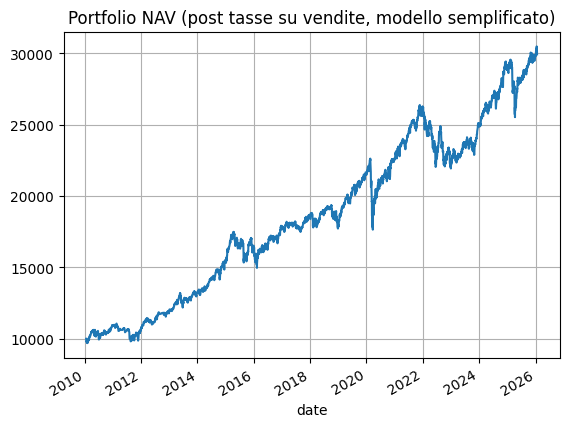

,date,asset,side,qty,price,value,pnl,tax
0,2010-03-31,WORLD_EUR_SW,SELL,0.787900,115.715127,91.171923,4.915676,1.278076
1,2010-03-31,SEGA_EUR,BUY,0.883472,101.750629,-89.893847,0.000000,0.000000
2,2010-04-30,WORLD_EUR_SW,SELL,0.639634,118.246030,75.634239,5.609507,1.458472
3,2010-04-30,SEGA_EUR,BUY,0.734929,100.929101,-74.175768,0.000000,0.000000
4,2010-05-31,SEGA_EUR,SELL,0.790421,101.457220,80.193868,1.220967,0.152621
5,2010-05-31,WORLD_EUR_SW,BUY,0.695601,115.067684,-80.041247,0.000000,0.000000
6,2010-08-31,SEGA_EUR,SELL,1.261865,104.029352,131.271033,5.194896,0.649362
7,2010-08-31,WORLD_EUR_SW,BUY,1.167111,111.918774,-130.621671,0.000000,0.000000
8,2010-09-30,WORLD_EUR_SW,SELL,0.592722,113.566806,67.313542,2.352292,0.611596
9,2010-09-30,SEGA_EUR,BUY,0.649364,102.718842,-66.701946,0.000000,0.000000


In [40]:
plt.figure()
port_nav["nav"].plot()
plt.title("Portfolio NAV (post tasse su vendite, modello semplificato)")
plt.grid(True)
plt.show()

trades.head(10)


## 13) Export risultati

In [17]:
out_dir = REPORTS / "exports"
out_dir.mkdir(parents=True, exist_ok=True)

port_nav.to_csv(out_dir / "portfolio_nav.csv")
trades.to_csv(out_dir / "portfolio_trades.csv", index=False)

out_dir


PosixPath('/content/reports/exports')

## Note fiscali (importante)
Questo notebook usa un modello semplificato:
- applica tassazione su **plusvalenze realizzate** dalle vendite
- gestisce uno **zainetto minus** con scadenza a 4 anni (carryforward)
- consente/nega compensazione minus a seconda di `income_type` impostato nel `TaxProfile`

Per rendere il modello più realistico in Italia, tipicamente serve distinguere:
- redditi di capitale vs redditi diversi (compensabilità minus)
- strumenti con aliquota 12,5% (titoli di Stato/white list) e look-through per fondi/ETF con quota pubblica
- regime amministrato vs dichiarativo (momento di prelievo imposta)
